In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
from liualgotrader.analytics import analysis 
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys
import pytz

In [2]:
day_to_analyze = datetime.strptime("2020-10-02", "%Y-%m-%d")

In [4]:
trades = analysis.load_trades(day_to_analyze)

In [5]:
algo_runs = analysis.load_runs(day_to_analyze)

In [66]:
symbol_name = []
counts = []
revenues = []

batch_ids = trades.batch_id.unique().tolist()

current_max = pd.options.display.max_rows
pd.set_option("display.max_rows", None)
for batch_id in batch_ids:
    how_was_my_day = pd.DataFrame()
    how_was_my_day["symbol"] = trades.loc[trades["batch_id"] == batch_id][
        "symbol"
    ].unique()
    how_was_my_day["revenues"] = how_was_my_day["symbol"].apply(
        lambda x: analysis.calc_revenue(x, trades)
    )
    how_was_my_day["count"] = how_was_my_day["symbol"].apply(
        lambda x: analysis.count_trades(x, trades)
    )

    print(
        f"batch_id:{batch_id}, total revenues=${round(sum(how_was_my_day['revenues']),2)}"
    )
    display(how_was_my_day)

pd.set_option("display.max_rows", current_max)

batch_id:688958e7-8e3a-440e-a2d3-8527d1b6eca9, total revenues=$-6.42


,symbol,revenues,count
0,BBBY,46.44,3
1,GALT,-99.66,3
2,PRPO,38.25,2
3,SPWR,8.55,2


In [71]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
minute_history = {}
for symbol in trades.symbol.unique().tolist():
    minute_history[symbol] = api.polygon.historic_agg_v2(
        symbol,
        1,
        "minute",
        _from=str((day_to_analyze - timedelta(days=10)).date()),
        to=str((day_to_analyze + timedelta(days=1)).date()),
    ).df

BBBY analysis with profit 46.44


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2187.00,-2187.00,buy,2020-10-02 10:28:36.028907-04:00,20.25,108,4.38%,,"{'buy': {'avg': 19.6473, 'macd': [0.051729196205780426, 0.04363155881093306, 0.05209829237553265, 0.07025543927229094, 0.0840155351113765], 'vwap': 20.2568, 'macd_signal': [0.06793391143029301, 0.06307344090642102, 0.06087841120024334, 0.06275381681465286, 0.06700616047399759]}, 'sell': None}",22.84,19.39
1,-201.72,1985.28,sell,2020-10-02 10:54:23.779726-04:00,20.68,96,6.6%,,"{'buy': None, 'sell': {'avg': 19.9257, 'rsi': [60.27916050039425, 60.27916050039425, 64.19846299508197], 'vwap': 20.6637, 'reasons': 'bail', 'movement': 0.020246913580246922, 'sell_macd': [0.07193896682793621, 0.06756304504022026, 0.06301605345186445, 0.05865455281870524, 0.05832280488613151], 'sell_macd_signal': [0.08348238354252854, 0.08029851584206689, 0.0768420233640264, 0.07320452925496217, 0.07022818438119603]}}",22.84,19.39
2,46.44,248.16,sell,2020-10-02 10:54:23.999473-04:00,20.68,12,6.6%,,"{'buy': None, 'sell': {'avg': 19.9257, 'rsi': [60.27916050039425, 60.27916050039425, 64.19846299508197], 'vwap': 20.6637, 'reasons': 'bail', 'movement': 0.020246913580246922, 'sell_macd': [0.07193896682793621, 0.06756304504022026, 0.06301605345186445, 0.05865455281870524, 0.05832280488613151], 'sell_macd_signal': [0.08348238354252854, 0.08029851584206689, 0.0768420233640264, 0.07320452925496217, 0.07022818438119603]}}",22.84,19.39


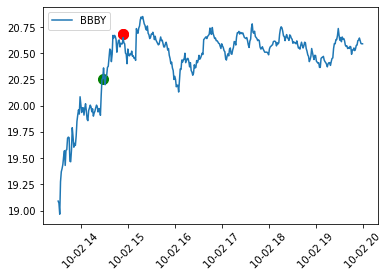

GALT analysis with profit -99.66


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-838.75,-838.75,buy,2020-10-02 10:22:43.991415-04:00,2.75,305,3.9%,,"{'buy': {'avg': 2.68, 'macd': [0.011552185778485935, 0.011778904316757544, 0.012620021071052978, 0.013701579541557152, 0.015421870884071431], 'vwap': 2.7496, 'macd_signal': [0.01320212065986171, 0.012917477391240877, 0.012857986127203297, 0.013026704810074067, 0.01350573802487354]}, 'sell': None}",3.06,2.65
1,-2491.50,-1652.75,buy,2020-10-02 10:22:44.196264-04:00,2.75,601,3.9%,,"{'buy': {'avg': 2.68, 'macd': [0.011552185778485935, 0.011778904316757544, 0.012620021071052978, 0.013701579541557152, 0.015421870884071431], 'vwap': 2.7496, 'macd_signal': [0.01320212065986171, 0.012917477391240877, 0.012857986127203297, 0.013026704810074067, 0.01350573802487354]}, 'sell': None}",3.06,2.65
2,-99.66,2391.84,sell,2020-10-02 14:13:26.258187-04:00,2.64,906,-0.26%,,"{'buy': None, 'sell': {'avg': 2.6865, 'rsi': [31.351975026617357, 36.21649651136396, 33.64867556585603], 'vwap': 2.64, 'reasons': 'stopped', 'movement': -0.03999999999999995, 'sell_macd': [-0.004983170583190866, -0.005425864462822005, -0.007258796518861743, -0.008073304659686809, -0.009122618734878962], 'sell_macd_signal': [-0.0024667328562628507, -0.0030585591775746817, -0.003898606645832094, -0.004733546248603037, -0.0056113607458582225]}}",3.06,2.65


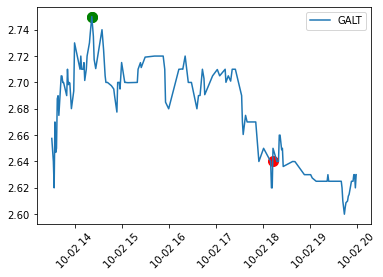

PRPO analysis with profit 38.25


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1079.50,-1079.50,buy,2020-10-02 10:28:29.574691-04:00,2.54,425,4.53%,,"{'buy': {'avg': 2.4473, 'macd': [0.017972027871907326, 0.021867590882726606, 0.023880723260060854, 0.02639835434475213, 0.02841304132740552], 'vwap': 2.5503, 'macd_signal': [0.017174870646006812, 0.01811341469335077, 0.019266876406692786, 0.020693171994304656, 0.022237145860924828]}, 'sell': None}",3.21,2.33
1,38.25,1117.75,sell,2020-10-02 10:32:55.957669-04:00,2.63,425,8.23%,,"{'buy': None, 'sell': {'avg': 2.5152, 'rsi': [65.6684437654658, 67.65117443217514, 79.34350603563581], 'vwap': 2.64, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.039370078740157514, 'sell_macd': [0.017271894980802394, 0.017333613242455304, 0.01716698314449072, 0.017328479390953166, 0.02190979491558709], 'sell_macd_signal': [0.014486250412111613, 0.015055722978180352, 0.015477975011442425, 0.015848075887344572, 0.017060419692993076]}}",3.21,2.33


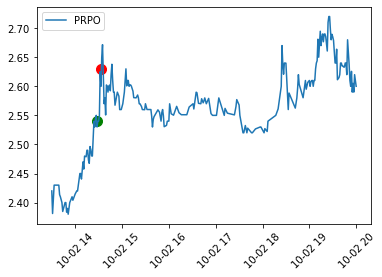

SPWR analysis with profit 8.55


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2373.48,-2373.48,buy,2020-10-02 10:28:29.738431-04:00,13.88,171,3.81%,,"{'buy': {'avg': 13.5, 'macd': [0.05615925331022176, 0.059795844934980025, 0.06675789427135825, 0.06985627601044264, 0.07305123291701499], 'vwap': 13.8896, 'macd_signal': [0.051442360952111695, 0.05311305774868536, 0.05584202505321994, 0.05864487524466448, 0.06152614677913458]}, 'sell': None}",15.53,13.34
1,8.55,2382.03,sell,2020-10-02 10:58:24.474518-04:00,13.93,171,4.19%,,"{'buy': None, 'sell': {'avg': 13.5974, 'rsi': [62.34803143073789, 50.6803140560944, 51.76052336689192], 'vwap': 13.92, 'reasons': 'bail post whipsawed', 'movement': 0.0028818443804033964, 'sell_macd': [0.027301220736498877, 0.029307674645693282, 0.029451565034083416, 0.02450587488173639, 0.020853312751572872], 'sell_macd_signal': [0.0233873722006345, 0.024571432689646254, 0.025547459158533688, 0.025339142303174227, 0.024441976392853955]}}",15.53,13.34


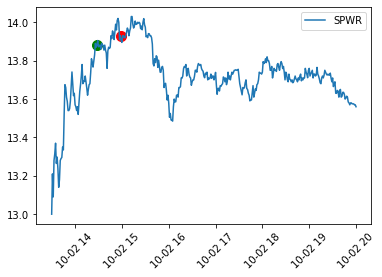

In [74]:
est = pytz.timezone("US/Eastern")
position = {}
for symbol in minute_history:
    symbol_df = trades.loc[trades["symbol"] == symbol]
    start_date = symbol_df["tstamp"].min().to_pydatetime()
    start_date = start_date.replace(hour=9, minute=30)
    cool_down_date = start_date + timedelta(minutes=5)
    try:
        minute_history_index = minute_history[symbol]["close"].index.get_loc(
            start_date, method="nearest"
        )
    except Exception as e:
        print(f"Error for {symbol}: {e}")
        continue

    cool_minute_history_index = minute_history[symbol]["close"].index.get_loc(
        cool_down_date, method="nearest"
    )
    open_price = minute_history[symbol]["close"][cool_minute_history_index]
    plt.plot(
        minute_history[symbol]["close"][minute_history_index:].between_time(
            "9:30", "16:00"
        ),
        label=symbol,
    )
    plt.xticks(rotation=45)

    delta = 0
    profit = 0

    operations = []
    deltas = []
    profits = []
    times = []
    prices = []
    qtys = []
    indicators = []
    target_price = []
    stop_price = []
    daily_change = []
    precent_vwap = []
    position[symbol] = 0
    for index, row in symbol_df.iterrows():
        if not position[symbol]:
            try:
                now = int(row["client_time"])
                continue
            except Exception:
                pass

        if position[symbol] >= 0 and row["operation"] == "buy":
            delta = -row["price"] * row["qty"]
            position[symbol] += row["qty"]
        elif position[symbol] <= 0 and row["operation"] == "sell":
            delta = row["price"] * row["qty"]
            position[symbol] -= row["qty"]
        elif position[symbol] > 0 and row["operation"] == "sell":
            delta = row["price"] * row["qty"]
            position[symbol] -= row["qty"]
        elif position[symbol] < 0 and row["operation"] == "buy":
            delta = -row["price"] * row["qty"]
            position[symbol] += row["qty"]

        profit += delta
        plt.scatter(
            row["tstamp"].to_pydatetime(),
            row["price"],
            c="g" if row["operation"] == "buy" else "r",
            s=100,
        )
        deltas.append(round(delta, 2))
        profits.append(round(profit, 2))
        operations.append(row["operation"])
        times.append(pytz.utc.localize(pd.to_datetime(row["tstamp"])).astimezone(est))
        prices.append(row["price"])
        qtys.append(row["qty"])
        indicators.append(row["indicators"])
        target_price.append(row["target_price"])
        stop_price.append(row["stop_price"])
        daily_change.append(
            f"{round(100.0 * (row['price'] - open_price) / open_price, 2)}%"
        )
        precent_vwap.append(
            f"{round(100.0 * (row['indicators']['avg'] - open_price) / open_price, 2)}%"
            if "avg" in row["indicators"]
            else ""
        )

    d = {
        "profit": profits,
        "trade": deltas,
        "operation": operations,
        "at": times,
        "price": prices,
        "qty": qtys,
        "daily change": daily_change,
        "vwap": precent_vwap,
        "indicators": indicators,
        "target price": target_price,
        "stop price": stop_price,
    }
    print(f"{symbol} analysis with profit ${round(profit, 2)}")
    display(HTML(pd.DataFrame(data=d).to_html()))
    plt.legend()
    plt.show()